# Assignment 2

## 2.1 RBF Netoworks
Using Gaussian RBFs to approximate simple fxns of one variable. There will be varying hidden nodes and one output node.  

## 3.1 Batch mode training using least squares- supervised learning of netowrk weights
- used to address regression problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Generate the training data & represent as column vectors. Also generate testing data set

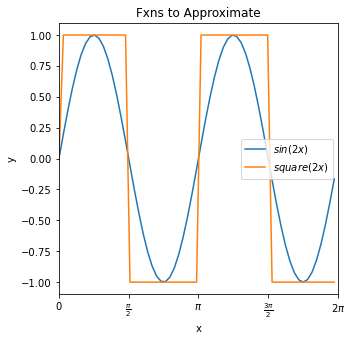

In [2]:
def data_generation(x):
    # interval = [0, 2*pi]
    sin_data = np.sin(2*x)
    square_data = np.sign(sin_data)
    return sin_data, square_data
def column_vec(data):
    x = np.reshape(data, (-1,1))
    return x

timestep = 0.1
x = np.arange(0, 2*np.pi, timestep)
sin_targets, square_targets = data_generation(x)

plt.figure(figsize=(5,5))
plt.plot(x, sin_targets, label="$sin(2x)$")
plt.plot(x, square_targets, label="$square(2x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
plt.title("Fxns to Approximate")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend()

# transform training data into column vectors
x_training =  column_vec(x)
sin_training_targets = column_vec(sin_targets)
square_training_targets = column_vec(square_targets)

# testing data
timestep = 0.05
x_test = np.arange(0, 2*np.pi, timestep)
sin_test_targets, square_test_targets = data_generation(x_test)

x_test =  column_vec(x_test)
sin_test_targets = column_vec(sin_test_targets)
square_test_targets = column_vec(square_test_targets)

Define RBF Network

In [21]:
class RBF_Network:
    def __init__(self, num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number=False, add_noise=False, online_learning=False, eta=0.1):
        self.num_nodes = num_nodes
        self.epochs = epochs
        self.variances = variances
        self.patterns = patterns
        self.targets = targets

        self.online_learning = online_learning
        self.eta = eta

        self.test_patterns = test_patterns
        self.test_targets = test_targets

        # set mu vector for cluster centers
        if cl_number:
            self.k_means_clusters(num_nodes)
        else:
            # self.random_clusters(num_nodes)
            self.mu_vector = column_vec(mu_vector)
        
        # self.mu_vector = column_vec(mu_vector)
        self.phi_of_x = np.reshape(np.array(self.mu_vector), (1,-1))
        self.hidden_weights = hidden_weights
        self.total_error = []
        self.f_of_x = []

        if add_noise == True:
            noise = np.reshape(np.random.normal(0,0.1,len(self.patterns)), (-1,1))
            self.patterns = self.patterns + noise

            noise = np.reshape(np.random.normal(0,0.1,len(self.targets)), (-1,1))
            self.targets = self.targets + noise
            
            noise = np.reshape(np.random.normal(0,0.1,len(self.test_patterns)), (-1,1))
            self.test_patterns = self.test_patterns + noise
            
            noise = np.reshape(np.random.normal(0,0.1,len(self.test_targets)), (-1,1))
            self.test_targets = self.test_targets + noise

    def train_network(self):
        """ For ea epoch, go through ea sample, which passes through each node to produce an output. """
        for e in range(0, self.epochs):
            for x in self.patterns:
                output = []
                for hid_node in range(0, self.num_nodes):
                    # appends output of phi(x) 
                    output.append((self.activation_fxn(self.mu_vector[hid_node], self.variances[hid_node], x))[0])
                output = np.array(output)
                # adds hidden_layer output as row to hidden layer output for other x's
                self.phi_of_x = np.vstack((self.phi_of_x,output))

            # calc f, the output for each sample and store in vector of all outputs
            self.f_of_x= np.dot(self.phi_of_x[1:], self.hidden_weights)

            # calc error per epoch
            self.calc_total_error()
            # print("The error of epoch ", e, ": ", self.total_error[e])

            # update the output weights
            self.update_output_weights()

            # reset phi output
            self.phi_of_x = np.reshape(self.mu_vector, (1,-1))
        

    def activation_fxn(self, position, variance, x):
        return np.exp( ((-(x-position)**2)) / (2*(variance**2)) )

    def calc_total_error(self):
        self.total_error.append( (sum((self.f_of_x-self.targets)**2))[0] )

    def update_output_weights(self):
        self.hidden_weights = np.dot(np.linalg.pinv(self.phi_of_x[1:]), self.targets)
    
    def k_means_clusters(self, number_of_centers):
        # random num for cluster centers from patterns
        centers_indecies = np.random.choice(len(self.patterns), size=number_of_centers, replace=False)
        cluster_distances = []
        for x in centers_indecies:
            # use np.random.shuffle(self.patterns[x])
            cluster_distances.append(self.patterns[x])

        cluster_distances = np.reshape(cluster_distances, (1,-1))
        data_distances = np.reshape(self.patterns, (-1,1))

        # distance between pattern and cluster center
        distances = (data_distances - cluster_distances)**2 

        # assigns smallest distance index (starting from 0) to row, thus assigning sample to cluster  
        cl_assignment = distances.argmin(axis=1)

        self.mu_vector = []
        # loop through each cluster to perform update
        for c in range(0, number_of_centers):
            summation = 0
            number = 0
            # loop through each assignment to check if in cluster
            for i in range(0, len(cl_assignment)):
                # if in cluster, the cluster needs to be moved
                if int(cl_assignment[i]) == int(c): 
                    summation += ((self.patterns[i])**2)**0.5
                    number += 1

            # reassign cluster centers
            if number == 0:
                number += 1
            self.mu_vector.append((summation/number)[0])
         
        # print("Cluster Centers: ", self.mu_vector)

    def validate(self, _plot=False):
        output = self.validation_output()

        if _plot == True:
            plt.figure(figsize=(5,5))
            plt.plot(self.test_patterns, output, label="Approximation")
            plt.plot(self.test_patterns, self.test_targets, label="Original")
            plt.xlabel("x")
            plt.ylabel("y")
            # plt.xlim([0,2*np.pi])
            plt.title("Outputs when number of RBF nodes = %i" % self.num_nodes)
            # labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
            # plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
            plt.legend()

        # return (sum((output-self.test_targets)**2))[0]
        return np.mean(np.abs(output-self.test_targets)) 


    def validation_output(self):

        for x in self.test_patterns:
            output = []
            for hid_node in range(0, self.num_nodes):
                # appends output of phi(x) 
                output.append((self.activation_fxn(self.mu_vector[hid_node], self.variances[hid_node], x))[0])
            output = np.array(output)
            # adds hidden_layer output as row to hidden layer output for other x's
            self.phi_of_x = np.vstack((self.phi_of_x,output))

        # calc f, the output for each sample and store in vector of all outputs
        self.f_of_x = np.dot(self.phi_of_x[1:], self.hidden_weights)
        
        # reset phi output  
        self.phi_of_x = np.reshape(self.mu_vector, (1,-1))

        return self.f_of_x
    


One test at 10 nodes for sign

In [24]:
num_nodes = 10
epochs = 100
# must always be as many as there are hidden nodes
variances = [1]*num_nodes
hidden_weights = [0.1]*num_nodes
cl_number = True

patterns = x_training
targets = sin_training_targets

test_patterns = x_test 
test_targets = sin_test_targets 

# targets = square_targets
rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number)
rbf_network.train_network()
e1 = rbf_network.validate(_plot=False)

### Test Nodes vs Sin RBF

0.6349506938763768
0.5979140827778233
0.5071231120840504
0.5158097165833249
0.20602509228738952
0.12958043397415975
Node:  7  results in 0.1 error.
0.09932691099479592
Node:  8  results in 0.1 error.
0.019036351885576824
Node:  9  results in 0.1 error.
0.012691282265767276
Node:  10  results in 0.1 error.
0.028257753934293427
Node:  11  results in 0.1 error.
0.01420121109412528
Node:  12  results in 0.1 error.
0.014093757700857953
Node:  13  results in 0.001 error.
0.0007035213097065691
Node:  14  results in 0.001 error.
4.341673446788768e-05
Node:  15  results in 0.001 error.
0.00037008372302069334


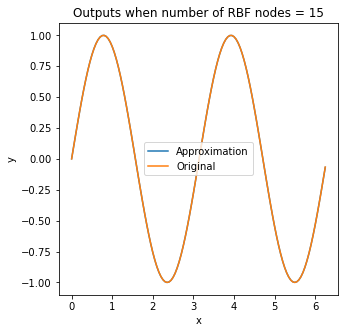

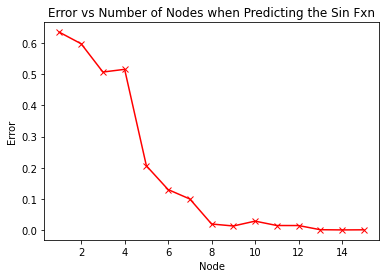

In [25]:
num_nodes_lst = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
error = []

epochs = 100
# must always be as many as there are hidden nodes
variances = [0.1]*num_nodes
hidden_weights = [0.1]*num_nodes
cl_number = True

patterns = x_training
targets = sin_training_targets

test_patterns = x_test 
test_targets = sin_test_targets 

for n in num_nodes_lst:
    num_nodes = n
    epochs = 100
    # must always be as many as there are hidden nodes
    variances = [1]*num_nodes
    hidden_weights = [0.1]*num_nodes

    rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number)
    rbf_network.train_network()

    if n == num_nodes_lst[-1]:
        error_ = rbf_network.validate(_plot=True)
        error.append(error_)
    else:
        error_ = rbf_network.validate(_plot=False)
        error.append(error_)
    
    if error_ < 0.001:
        print("Node: ", n, " results in 0.001 error.")
    elif error_ < 0.01:
        print("Node: ", n, " results in 0.01 error.")
    elif error_ < 0.1:
        print("Node: ", n, " results in 0.1 error.") 
    
    print(error_)

plt.figure()
plt.plot(num_nodes_lst, error, color='red', marker='x')
plt.xlabel("Node")
plt.ylabel("Error")
plt.title("Error vs Number of Nodes when Predicting the Sin Fxn")
plt.show()

### Test Nodes for Square RBF

0.37378003084704814
0.2857072495352291
0.21489346839960144
0.17590908966367208
0.17266280310494558
0.17988743857731895
0.17533546780783033


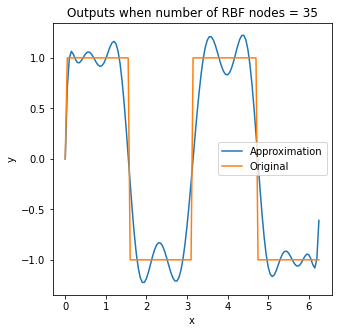

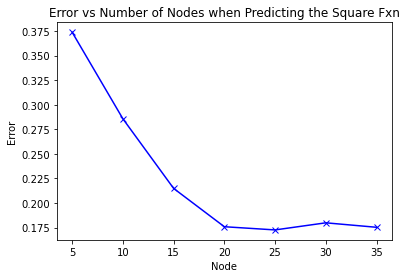

In [30]:
num_nodes_lst = [5,10,15,20,25, 30, 35] 
# num_nodes_lst = [30,35,40,45,50]
error = []

epochs = 150
# must always be as many as there are hidden nodes
variances = [0.1]*num_nodes
hidden_weights = [0.1]*num_nodes
cl_number = True

patterns = x_training
targets = square_training_targets

test_patterns = x_test 
test_targets = square_test_targets 

for n in num_nodes_lst:
    num_nodes = n
    epochs = 100
    # must always be as many as there are hidden nodes
    variances = [1]*num_nodes
    hidden_weights = [0.1]*num_nodes

    rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number)
    rbf_network.train_network()

    if n == num_nodes_lst[-1]:
        error_ = rbf_network.validate(_plot=True)
        error.append(error_)
    else:
        error_ = rbf_network.validate(_plot=False)
        error.append(error_)
    
    if error_ < 0.001:
        print("Node: ", n, " results in 0.001 error.")
    elif error_ < 0.01:
        print("Node: ", n, " results in 0.01 error.")
    elif error_ < 0.1:
        print("Node: ", n, " results in 0.1 error.") 

    print(error_)

# plt.figure(figsize=(5,5))
plt.figure()
plt.plot(num_nodes_lst, error, color='blue', marker='x')
plt.xlabel("Node")
plt.ylabel("Error")
plt.title("Error vs Number of Nodes when Predicting the Square Fxn")
plt.show()

## 3.2 Regression with noise

Add gaussion noise to the data from above. Mean = 0, variance = 0.1.

Plots all highest node graphs got fot the different variances.

### Sin RBF with Noise

Node:  1  Var:  0.01  Error:  61272.20090108063
Node:  1  Var:  0.05  Error:  0.6508454873735607
Node:  1  Var:  0.1  Error:  0.641391532272889
Node:  1  Var:  0.2  Error:  0.6304793855951863
Node:  1  Var:  0.5  Error:  0.6325832197137209
Node:  2  Var:  0.01  Error:  198503.89308924117
Node:  2  Var:  0.05  Error:  0.6199941487889964
Node:  2  Var:  0.1  Error:  0.5910237389974241
Node:  2  Var:  0.2  Error:  0.48290354318862816
Node:  2  Var:  0.5  Error:  0.6003703155643699
Node:  3  Var:  0.01  Error:  158856691498.1042
Node:  3  Var:  0.05  Error:  0.5953276794378143
Node:  3  Var:  0.1  Error:  0.577155098343209
Node:  3  Var:  0.2  Error:  0.5424747260326
Node:  3  Var:  0.5  Error:  0.45657946605530186
Node:  4  Var:  0.01  Error:  124.57747572931565
Node:  4  Var:  0.05  Error:  0.6187247268172338
Node:  4  Var:  0.1  Error:  0.5585742327485269
Node:  4  Var:  0.2  Error:  0.3232678654167921
Node:  4  Var:  0.5  Error:  0.43675970635770495
Node:  5  Var:  0.01  Error:  1.3163

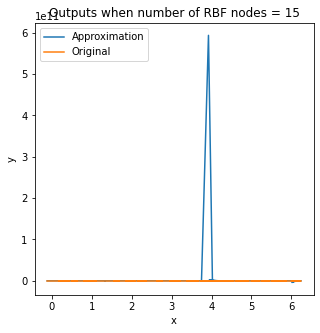

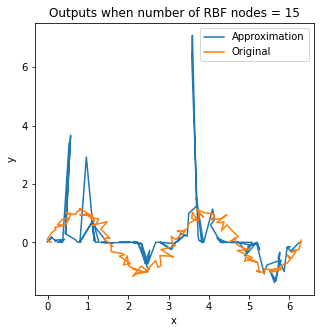

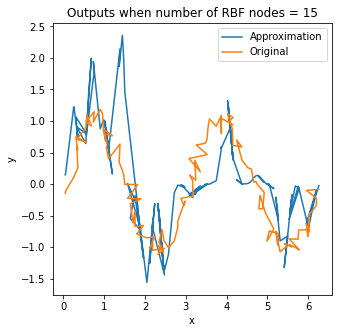

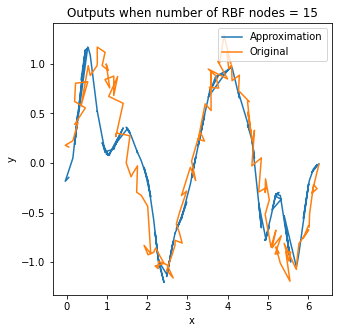

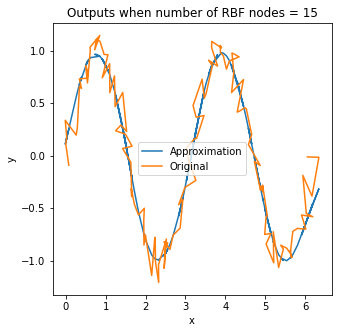

In [45]:
num_nodes_lst = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
error = []

epochs = 100
# must always be as many as there are hidden nodes
variances_lst = [0.01, 0.05, 0.1, 0.2, 0.5]
hidden_weights = [0.1]*num_nodes
cl_number = True

patterns = x_training
targets = sin_training_targets

test_patterns = x_test 
test_targets = sin_test_targets 

for n in num_nodes_lst:
    num_nodes = n
    for var in variances_lst:
    # must always be as many as there are hidden nodes
        variances = [var]*num_nodes
        hidden_weights = [0.1]*num_nodes

        rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number, add_noise=True)
        rbf_network.train_network()

        if n == num_nodes_lst[-1]:
            error_ = rbf_network.validate(_plot=False)
            error.append(error_)
        else:
            error_ = rbf_network.validate(_plot=False)
            error.append(error_)
        
        # if error_ < 0.001:
        #     print("Node: ", n, " with var ", var, " results in 0.001 error.")
        # elif error_ < 0.01:
        #     print("Node: ", n, " with var ", var, " results in 0.01 error.")
        # elif error_ < 0.1:
        #     print("Node: ", n, " with var ", var, " results in 0.1 error.") 

        print("Node: ", n, " Var: ", var, " Error: ", error_)


### Square RBF with Noise

Node:  1  Var:  0.01  Error:  2.992833320184462e+31
Node:  1  Var:  0.05  Error:  1.019806804822512
Node:  1  Var:  0.1  Error:  0.9935353485441629
Node:  1  Var:  0.2  Error:  0.9921996039776584
Node:  1  Var:  0.5  Error:  1.0014410468908221
Node:  5  Var:  0.01  Error:  1928546555.4213736
Node:  5  Var:  0.05  Error:  0.9985182719366437
Node:  5  Var:  0.1  Error:  0.7896473030597263
Node:  5  Var:  0.2  Error:  0.7443953122774443
Node:  5  Var:  0.5  Error:  0.3829351378360129
Node:  10  Var:  0.01  Error:  2513026.7412833762
Node:  10  Var:  0.05  Error:  1.3099920965737304
Node:  10  Var:  0.1  Error:  0.6421786821927502
Node:  10  Var:  0.2  Error:  0.4696198641858433
Node:  10  Var:  0.5  Error:  0.3129916864473484
Node:  15  Var:  0.01  Error:  2250786553177.4766
Node:  15  Var:  0.05  Error:  4.591940345107763
Node:  15  Var:  0.1  Error:  0.5650504178490432
Node:  15  Var:  0.2  Error:  0.3418882388181316
Node:  15  Var:  0.5  Error:  0.25907132161689483
Node:  20  Var:  0.0

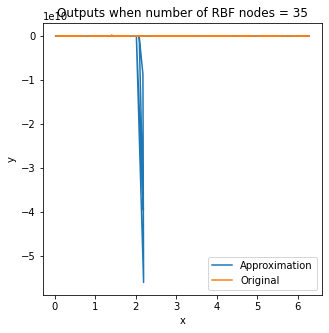

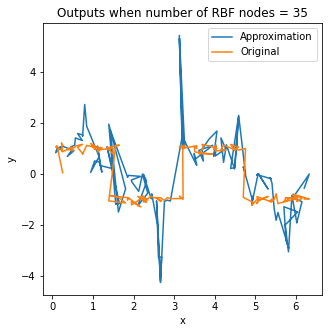

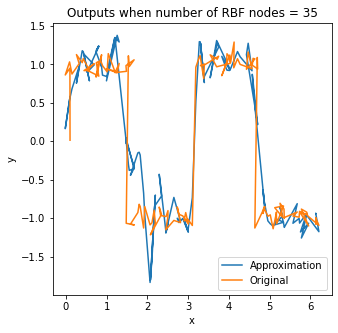

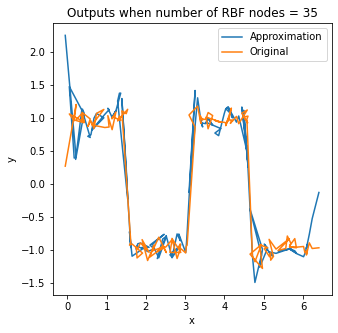

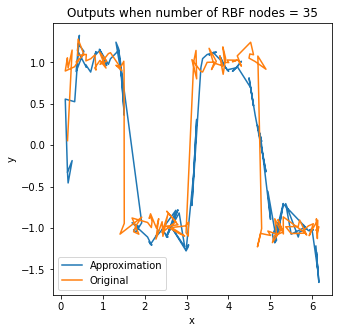

In [46]:
num_nodes_lst = [1,5,10,15,20,25,30,35] 
# num_nodes_lst = [30,35,40,45,50]
error = []

epochs = 100
# must always be as many as there are hidden nodes
variances_lst = [0.01, 0.05, 0.1, 0.2, 0.5]
# variances = [0.5]*num_nodes
hidden_weights = [0.1]*num_nodes
cl_number = True

patterns = x_training
targets = square_training_targets

test_patterns = x_test 
test_targets = square_test_targets 

for n in num_nodes_lst:
    num_nodes = n
    for var in variances_lst:
    # must always be as many as there are hidden nodes
        variances = [var]*num_nodes
        hidden_weights = [0.1]*num_nodes

        rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number, add_noise=True)
        rbf_network.train_network()

        if n == num_nodes_lst[-1]:
            error_ = rbf_network.validate(_plot=True)
            error.append(error_)
        else:
            error_ = rbf_network.validate(_plot=False)
            error.append(error_)
        
        # if error_ < 0.001:
        #     print("Node: ", n, " with var ", var, " results in 0.001 error.")
        # elif error_ < 0.01:
        #     print("Node: ", n, " with var ", var, " results in 0.01 error.")
        # elif error_ < 0.1:
        #     print("Node: ", n, " with var ", var, " results in 0.1 error.") 

        print("Node: ", n, " Var: ", var, " Error: ", error_)


### Online Delta Rule
- Patterns will be single values going in with single value targets, so no matrix operations. 
- The training network will be sequentially run for each input pattern (loop through samples)
- Set the cl_centers. 

- Note: epochs is not used. online_learning=True. add_noise=True. cl_number=False & manually set (see else). eta must be set. patterns and targets will be scalar.


Delta training network

In [164]:
class RBF_DeltaNetwork:
    def __init__(self, num_nodes, variances, hidden_weights,cl_number=False, eta=0.1):
        self.num_nodes = num_nodes
        self.variances = variances
        self.hidden_weights = np.reshape(hidden_weights, (-1,1))
        self.eta = eta

        # self.phi_of_x = np.reshape(np.array(self.hidden_weights), (1,-1))
        self.instantaneous_error = []
        self.all_f_of_x = []

        # set mu vector for cluster centers
        if cl_number:
            self.k_means_clusters(num_nodes)
        else:
            self.chosen_clusters(num_nodes)

        self.validation_output = []

    def train_network(self, pattern, target):
        """ Has single input, and does Delta rule """
        self.pattern = pattern
        self.target = target

        output = []
        for hid_node in range(0, self.num_nodes):
            # appends output of phi(x) 
            output.append((self.activation_fxn(self.mu_vector[hid_node], self.variances[hid_node], self.pattern)))
        # adds hidden_layer output as row to hidden layer output for other x's
        self.phi_of_x = np.reshape(np.array(output), (1,-1))

        # calc f, the output for each sample and store in vector of all outputs
        self.f_of_x= np.dot(self.phi_of_x, self.hidden_weights)

        # calc error per epoch
        self.calc_total_error()
        # print("The error of epoch ", e, ": ", self.total_error[e])

        # update the output weights
        self.update_output_weights()        

    def activation_fxn(self, position, variance, x):
        activation_out = np.exp( ((-(x-position)**2)) / (2*(variance**2)) )
        return activation_out

    def calc_total_error(self):
        self.e = self.target - self.f_of_x
        self.instantaneous_error.append((0.5*((self.e)**2))[0])

    def update_output_weights(self):
        self.hidden_weights += self.eta*self.e*np.reshape(self.phi_of_x, (-1,1))
    
    def k_means_clusters(self, number_of_centers):
        # random num for cluster centers from patterns
        centers_indecies = np.random.choice(len(self.patterns), size=number_of_centers, replace=False)
        cluster_distances = []
        for x in centers_indecies:
            # use np.random.shuffle(self.patterns[x])
            cluster_distances.append(self.patterns[x])

        cluster_distances = np.reshape(cluster_distances, (1,-1))
        data_distances = np.reshape(self.patterns, (-1,1))

        # distance between pattern and cluster center
        distances = (data_distances - cluster_distances)**2 

        # assigns smallest distance index (starting from 0) to row, thus assigning sample to cluster  
        cl_assignment = distances.argmin(axis=1)

        self.mu_vector = []
        # loop through each cluster to perform update
        for c in range(0, number_of_centers):
            summation = 0
            number = 0
            # loop through each assignment to check if in cluster
            for i in range(0, len(cl_assignment)):
                # if in cluster, the cluster needs to be moved
                if int(cl_assignment[i]) == int(c): 
                    summation += ((self.patterns[i])**2)**0.5
                    number += 1

            # reassign cluster centers
            if number == 0:
                number += 1
            self.mu_vector.append((summation/number)[0])
         
        # print("Cluster Centers: ", self.mu_vector)
    
    def chosen_clusters(self, num_nodes):
        self.mu_vector = np.arange(0,2*np.pi,2*np.pi/num_nodes)
    
    def plot_training_instantaneous_error(self):
        plt.figure()
        plt.plot(np.arange(0,len(self.instantaneous_error),1), self.instantaneous_error)
        plt.xlabel("Sample")
        plt.ylabel("Instantaneous Error")
        # plt.xlim([0,2*np.pi])
        plt.title("Instantaneous Error vs sample")
        # labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
        # plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
        plt.show()

    def validate(self,patterns,targets,_plot=False):
        output = self.validation_of_network(patterns)
        # print(np.shape(output))
        # print(output)
        if _plot == True:
            plt.figure()
            plt.plot(patterns, targets, label="Original")
            plt.plot(patterns, output, label="Approximation", color='orange')
            plt.xlabel("x")
            plt.ylabel("y")
            # plt.xlim([0,2*np.pi])
            plt.title("Approx. with online learning, Delta rule with eta = %f" % self.eta)
            # labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
            # plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
            plt.legend()
            plt.show()

        # return np.mean(np.abs(output-self.test_targets)) 


    def validation_of_network(self,pattern):
        for p in pattern:
            output = []
            # print(p)
            for hid_node in range(0, self.num_nodes):
                # appends output of phi(x) 
                output.append((self.activation_fxn(self.mu_vector[hid_node], self.variances[hid_node], p)))
            # adds hidden_layer output as row to hidden layer output for other x's
            self.phi_of_x = np.reshape(np.array(output), (1,-1))

            # calc f, the output for each sample and store in vector of all outputs
            self.validation_output.append((np.dot(self.phi_of_x, self.hidden_weights))[0])

        return self.validation_output
            # for hid_node in range(0, self.num_nodes):
            #     # appends output of phi(x) 
            #     output.append((self.activation_fxn(self.mu_vector[hid_node], self.variances[hid_node], self.pattern)))
            # # adds hidden_layer output as row to hidden layer output for other x's
            # self.phi_of_x = np.reshape(np.array(output), (1,-1))

            # # calc f, the output for each sample and store in vector of all outputs
            # self.f_of_x= np.dot(self.phi_of_x, self.hidden_weights)

    
def add_noise(patterns, targets, test_patterns, test_targets):
    noise = np.reshape(np.random.normal(0,0.1,len(patterns)), (-1,1))
    patterns = patterns + noise

    noise = np.reshape(np.random.normal(0,0.1,len(targets)), (-1,1))
    targets = targets + noise
    
    noise = np.reshape(np.random.normal(0,0.1,len(test_patterns)), (-1,1))
    test_patterns = test_patterns + noise
    
    noise = np.reshape(np.random.normal(0,0.1,len(test_targets)), (-1,1))
    test_targets = test_targets + noise

    return patterns,targets,test_patterns,test_targets

Delta rule algo

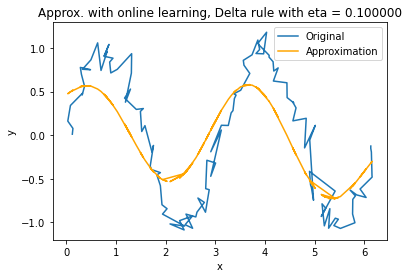

In [165]:
num_nodes = 10

# must always be as many as there are hidden nodes
variances = [0.5]*num_nodes
hidden_weights = [0.1]*num_nodes
eta = 0.1 

patterns,targets,test_patterns,test_targets = add_noise(x_training, sin_training_targets, x_test, sin_test_targets)

# def __init__(self, num_nodes, variances, hidden_weights, cl_number=False, add_noise=False, eta=0.1):
rbf_delta_network = RBF_DeltaNetwork(num_nodes, variances, hidden_weights, cl_number=False, eta=eta)

# loops through the patterns and targets to simulate 'online learning'
for i in range(0, len(patterns)):
    rbf_delta_network.train_network(patterns[i], targets[i])

# rbf_delta_network.plot_training_instantaneous_error()


rbf_delta_network.validate(test_patterns,test_targets, _plot=True)

### Delta rule algo for various eta for Sin
variances between 0.2 and 0.3 are best

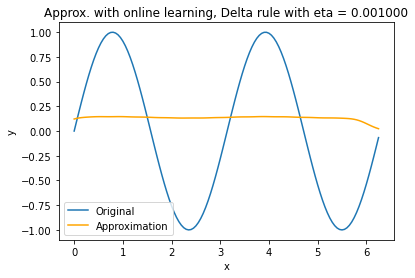

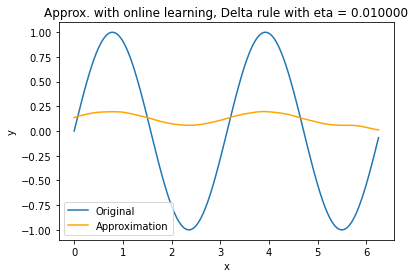

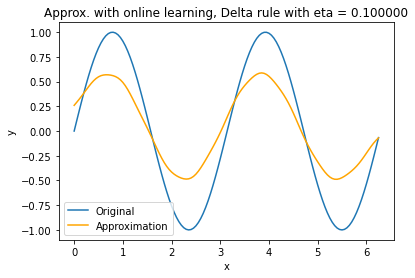

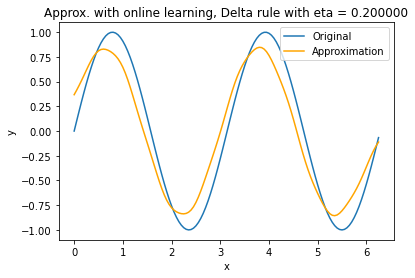

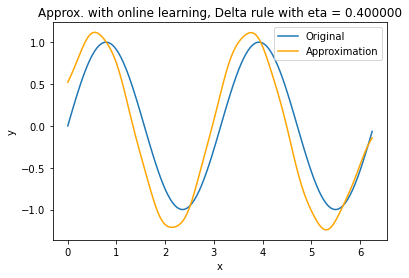

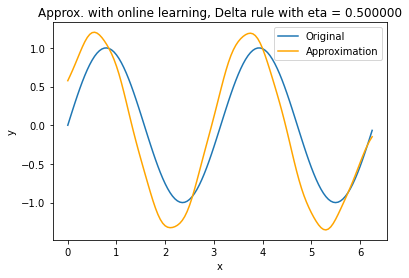

In [167]:
num_nodes = 13

# must always be as many as there are hidden nodes
variances = [0.27]*num_nodes
hidden_weights = [0.1]*num_nodes
eta_lst = [0.001, 0.01, 0.1, 0.2, 0.4, 0.5] 

patterns,targets,test_patterns,test_targets = add_noise(x_training, sin_training_targets, x_test, sin_test_targets)
# patterns,targets,test_patterns,test_targets = x_training, sin_training_targets, x_test, sin_test_targets

for eta in eta_lst:
    rbf_delta_network = RBF_DeltaNetwork(num_nodes, variances, hidden_weights, cl_number=False, eta=eta)

    # loops through the patterns and targets to simulate 'online learning'
    for i in range(0, len(patterns)):
        rbf_delta_network.train_network(patterns[i], targets[i])

    # rbf_delta_network.plot_training_instantaneous_error()

    rbf_delta_network.validate(test_patterns,test_targets, _plot=True)

### Delta rule algo for various eta for Square
variances between 0.2 and 0.3 are best

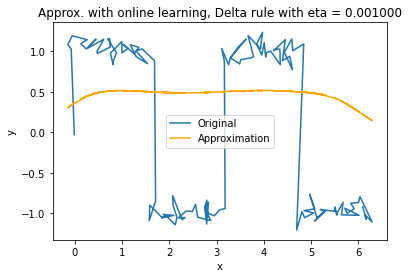

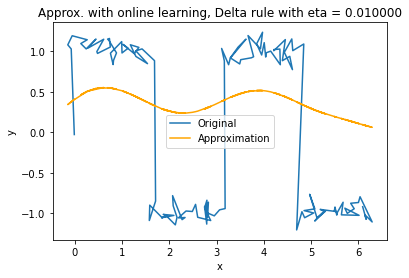

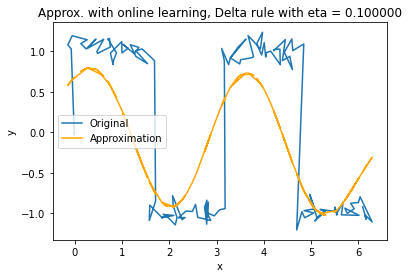

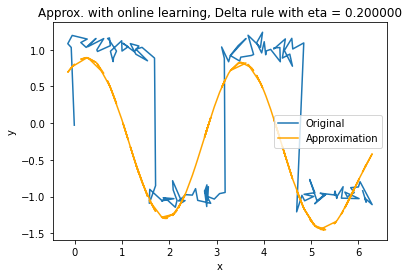

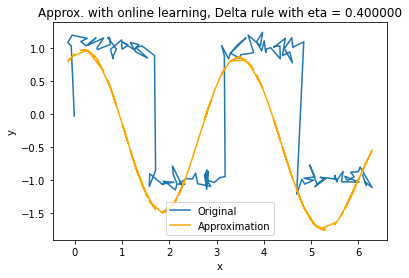

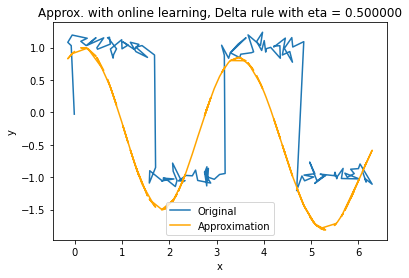

In [170]:
num_nodes = 13

# must always be as many as there are hidden nodes
variances = [0.5]*num_nodes
hidden_weights = [0.2]*num_nodes

eta_lst = [0.001, 0.01, 0.1, 0.2, 0.4, 0.5] 

patterns,targets,test_patterns,test_targets = add_noise(x_training, square_training_targets, x_test, square_test_targets)
# patterns,targets,test_patterns,test_targets = x_training, square_training_targets, x_test, square_test_targets

for eta in eta_lst:
    rbf_delta_network = RBF_DeltaNetwork(num_nodes, variances, hidden_weights, cl_number=False, eta=eta)

    # loops through the patterns and targets to simulate 'online learning'
    for i in range(0, len(patterns)):
        rbf_delta_network.train_network(patterns[i], targets[i])

    # rbf_delta_network.plot_training_instantaneous_error()

    rbf_delta_network.validate(test_patterns,test_targets, _plot=True)

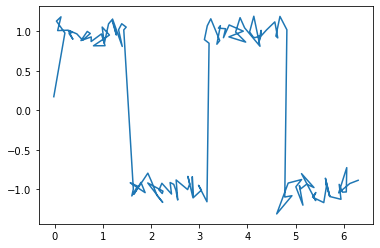

In [158]:
plt.figure()
plt.plot(test_patterns,test_targets)
plt.show()